In [13]:
# import module
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize
from numba.typed import List
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from scipy import signal
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d

In [2]:

# Store Pdf with convert_from_path function
images = convert_from_path(r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\new_data\left-right-spirals.pdf')



In [4]:
df = {}
iterations = [60, 640, 1170, 1730, 2400]
left_right = [200, 800, 1500]
for i in range(len(images)):
    for rl in range(2):
        for it in range(4):
            df['p{:02}_{}_{}'.format(i, rl, it)] = np.array(images[i])[iterations[it]:iterations[it+1], left_right[rl]:left_right[rl+1]]
            
    #print(np.array(images[i]))
    
    #break
    # Save pages as images in the pdf
    #images[i].save('page'+ str(i) +'.jpg', 'JPEG')

In [ ]:
#tmp = []
#for i in range(df['p01_1_2'].shape[0]):
 #   for j in range(df['p01_1_2'].shape[1]):
for name in df:

    tmp = np.array((df[name] < [190, 0, 0]) * 255, dtype=np.uint16)
    #print(tmp.shape)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
    _, tmp = cv2.threshold(tmp, 50, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)
    
    tmp = skeletonize(tmp)
    plt.imshow(tmp, cmap='grey')
    plt.show()

In [ ]:
tmp


p00_0_0


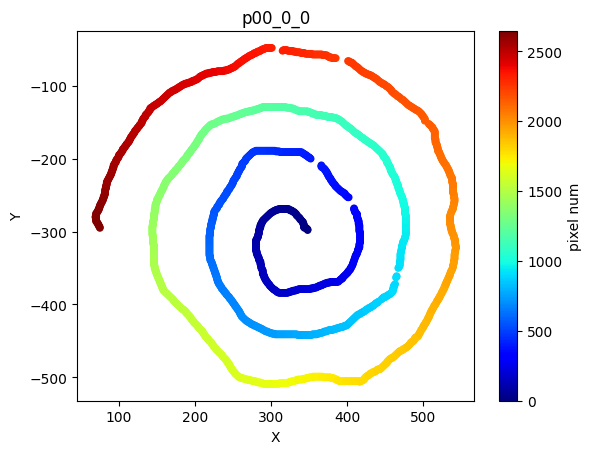

p00_0_1
p00_0_2
p00_0_3
p00_1_0
p00_1_1
p00_1_2
p00_1_3
p01_0_0
p01_0_1
p01_0_2
p01_0_3
p01_1_0
p01_1_1
p01_1_2
p01_1_3
p02_0_0
p02_0_1
p02_0_2
p02_0_3
p02_1_0
p02_1_1
p02_1_2
p02_1_3
p03_0_0
p03_0_1
p03_0_2
p03_0_3
p03_1_0
p03_1_1
p03_1_2
p03_1_3
p04_0_0
p04_0_1
p04_0_2
p04_0_3
p04_1_0
p04_1_1
p04_1_2
p04_1_3
p05_0_0
p05_0_1
p05_0_2
p05_0_3
p05_1_0
p05_1_1
p05_1_2
p05_1_3
p06_0_0
p06_0_1
p06_0_2
p06_0_3
p06_1_0
p06_1_1
p06_1_2
p06_1_3
p07_0_0
p07_0_1
p07_0_2
p07_0_3
p07_1_0
p07_1_1
p07_1_2
p07_1_3
p08_0_0
p08_0_1
p08_0_2
p08_0_3
p08_1_0
p08_1_1
p08_1_2
p08_1_3
p09_0_0
p09_0_1
p09_0_2
p09_0_3
p09_1_0
p09_1_1
p09_1_2
p09_1_3
p10_0_0
p10_0_1
p10_0_2
p10_0_3
p10_1_0
p10_1_1
p10_1_2
p10_1_3


In [10]:
names = []
trace_distances_all = []
trace_angle_all = []
all_paths = []
first = True

for name in df:
    print(name)
    tmp = np.array((df[name] < [190, 0, 0]) * 255, dtype=np.uint16)
    #print(tmp.shape)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
    _, tmp = cv2.threshold(tmp, 50, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)
    
    tmp = skeletonize(tmp)
    skeleton_img_cropped = np.array(tmp*1, np.uint8)
    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=200)
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
    # follow the start point through the spiral
    skeleton_img_trace = skeleton_img_cropped.copy()
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=200)
    trace_path_typed = List()
    [trace_path_typed.append(i) for i in trace_path]

    # turn the coordinates in angle and distance for an alternative representation
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(name)
    all_paths.append(trace_path)

    if first:
        plt.imshow(tmp, 'grey')
        plt.show()
        plt_traced(trace_path, name)
    first = False

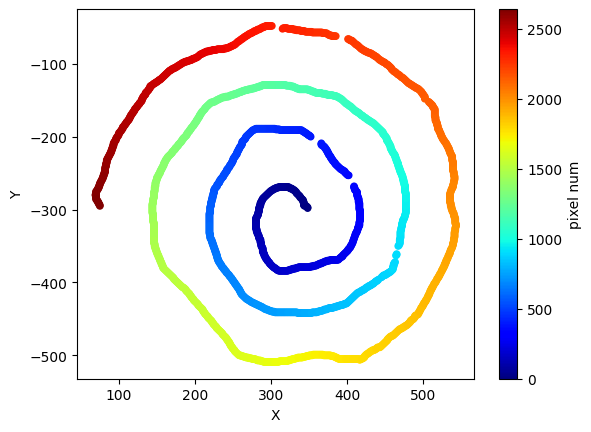

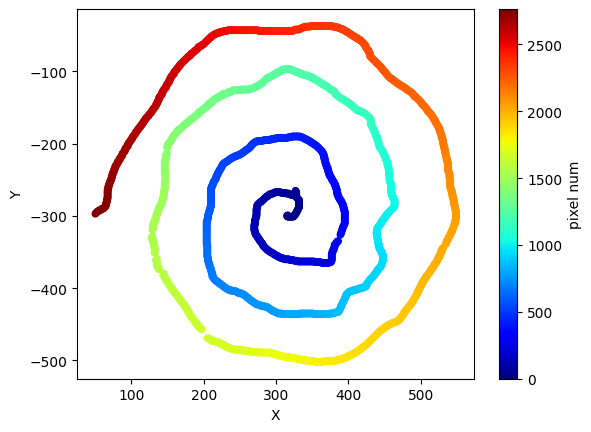

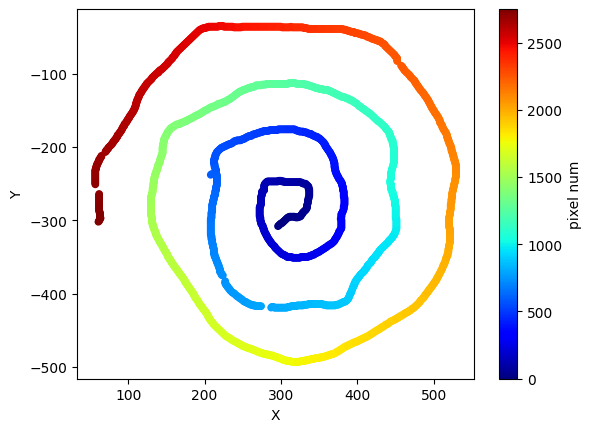

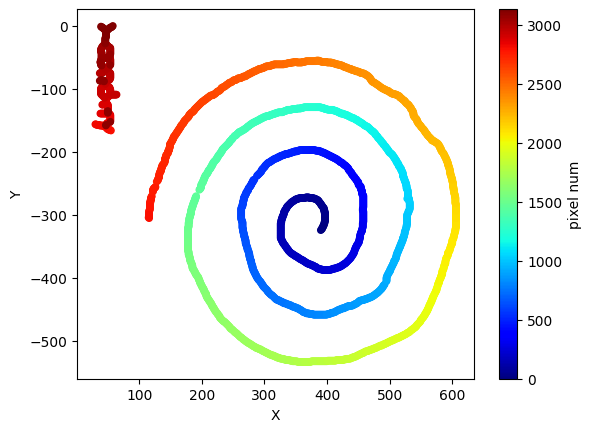

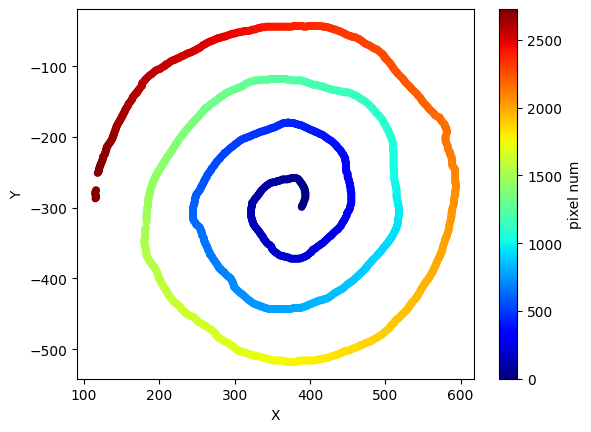

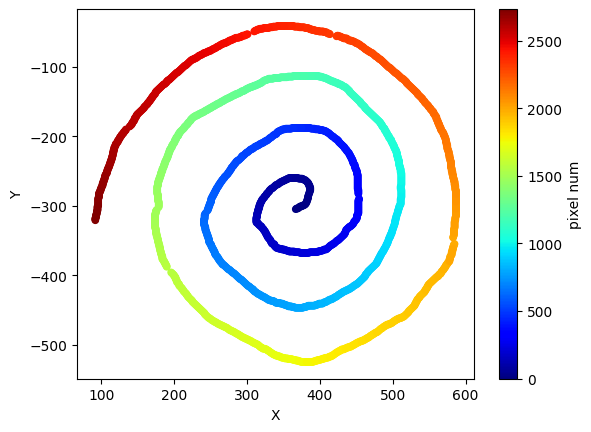

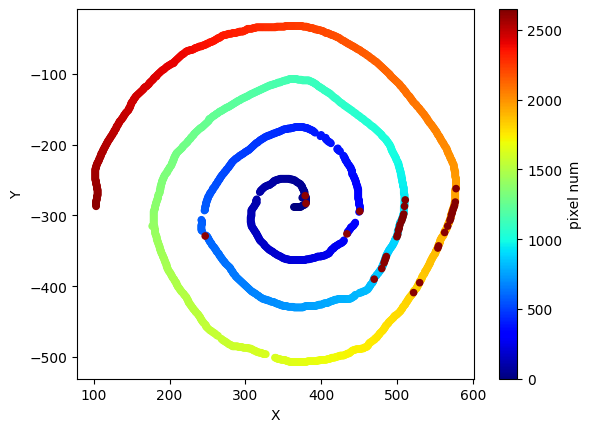

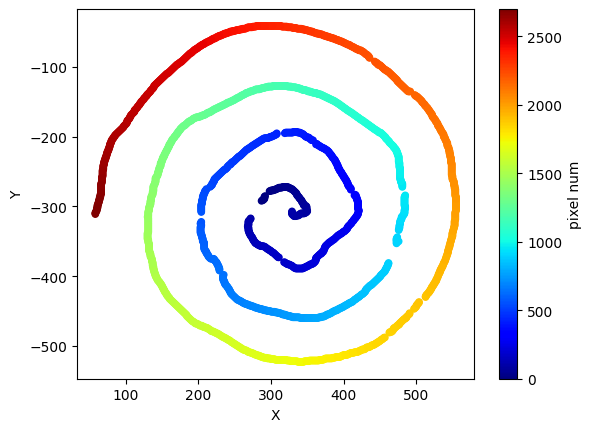

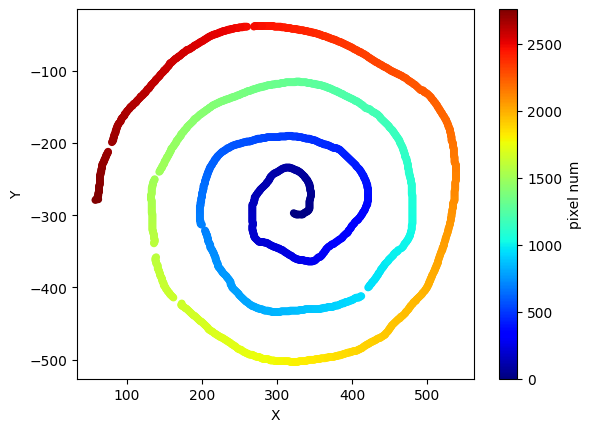

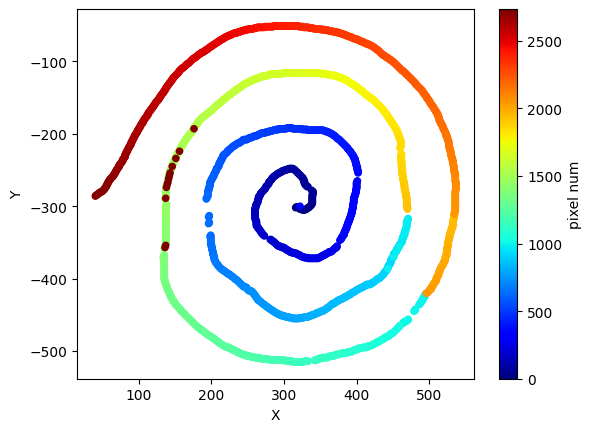

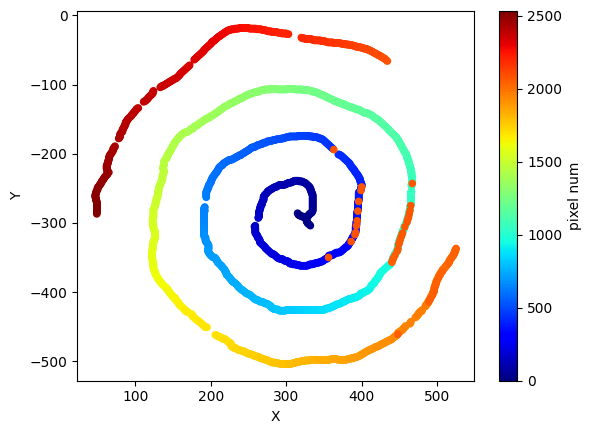

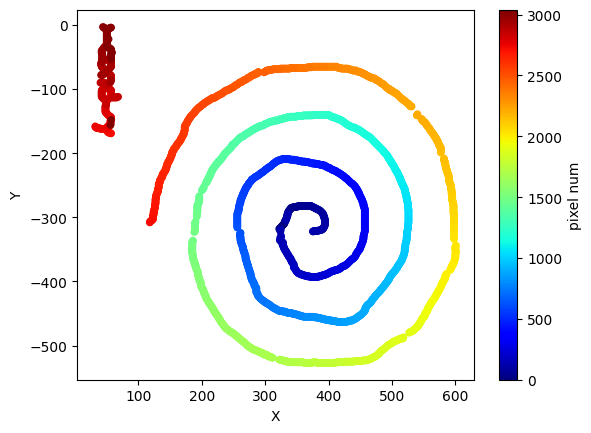

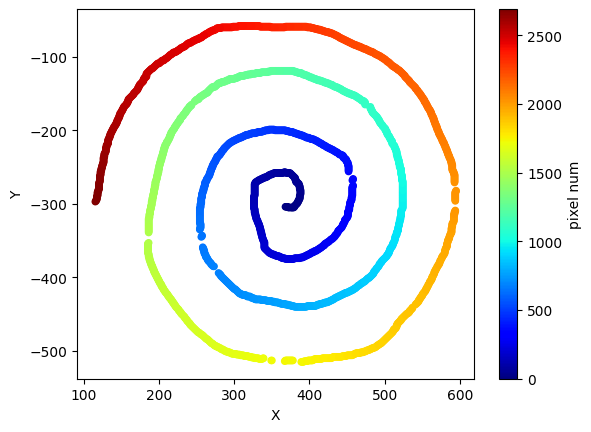

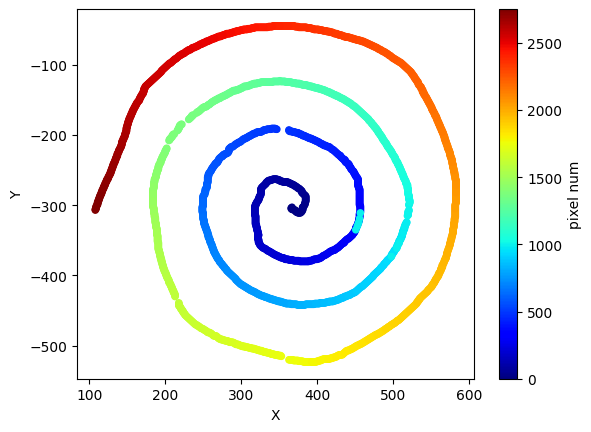

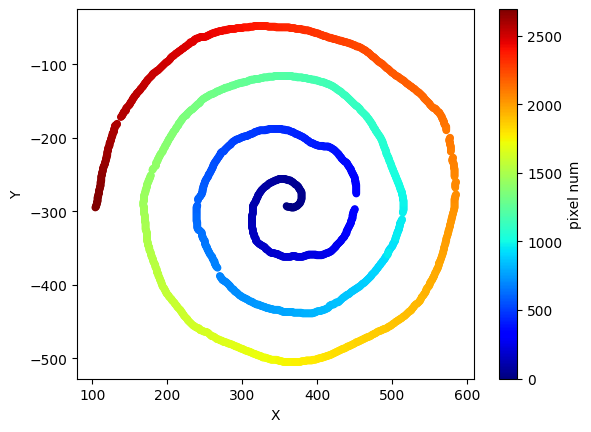

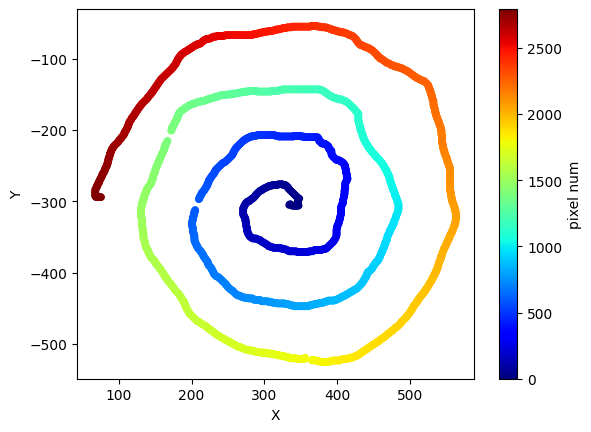

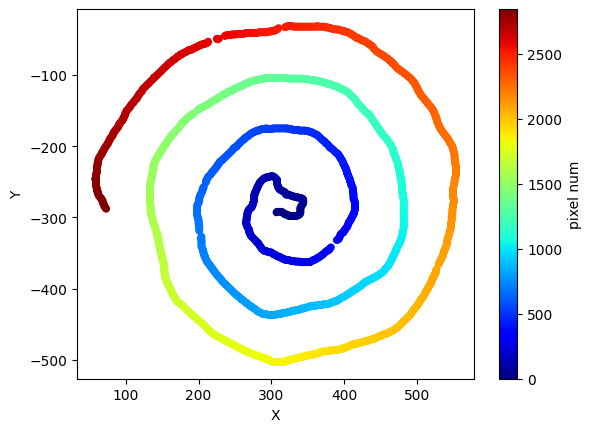

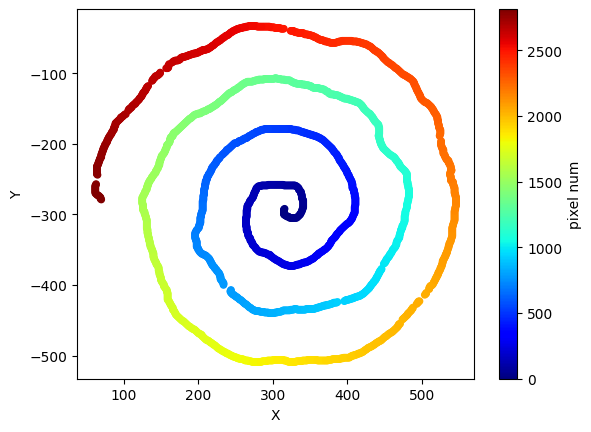

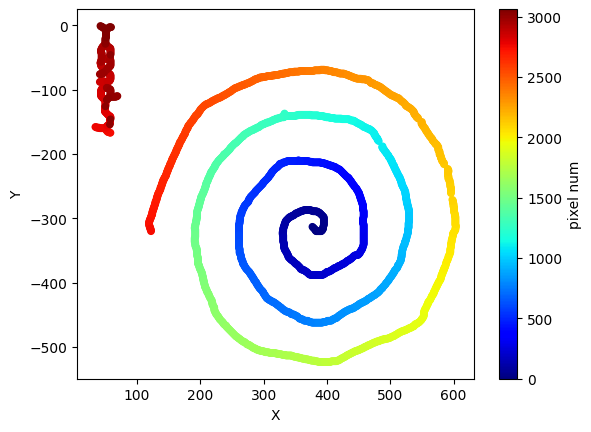

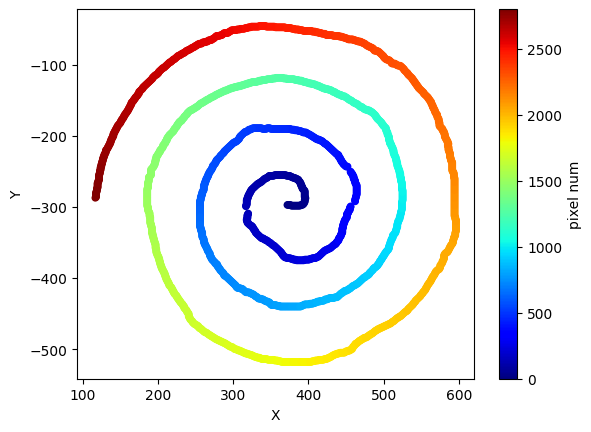

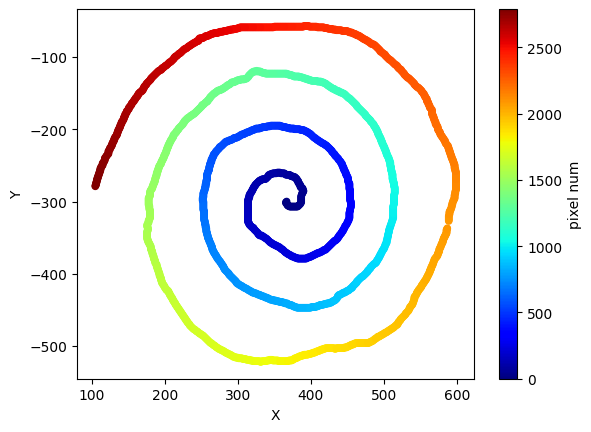

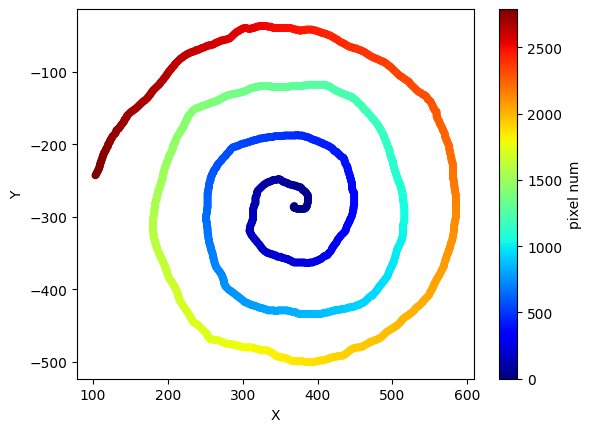

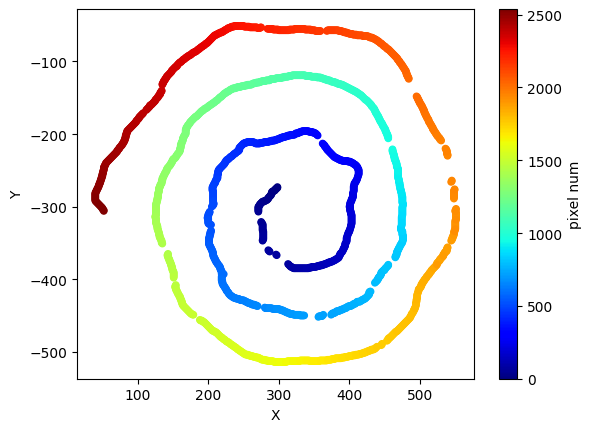

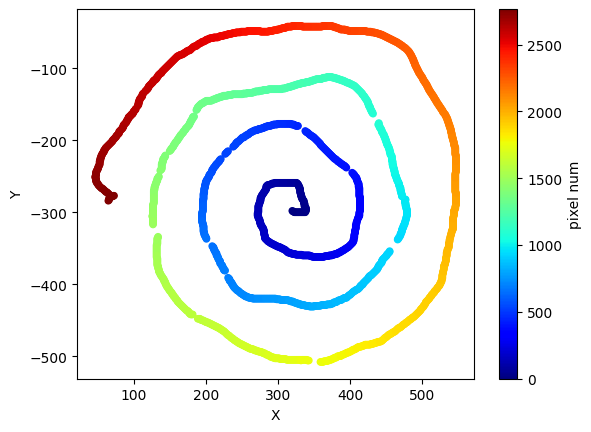

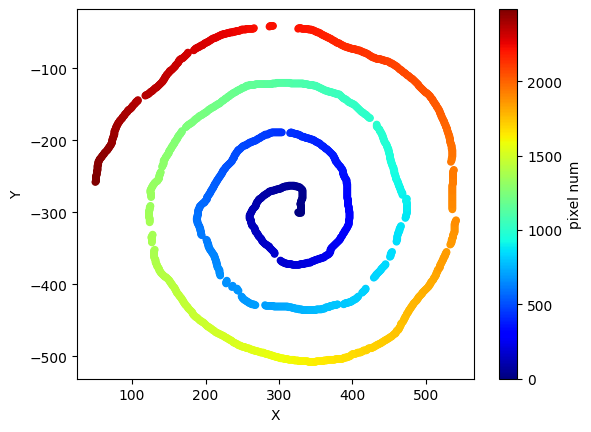

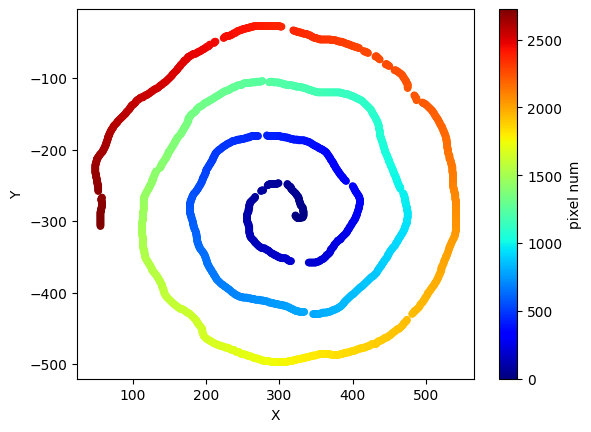

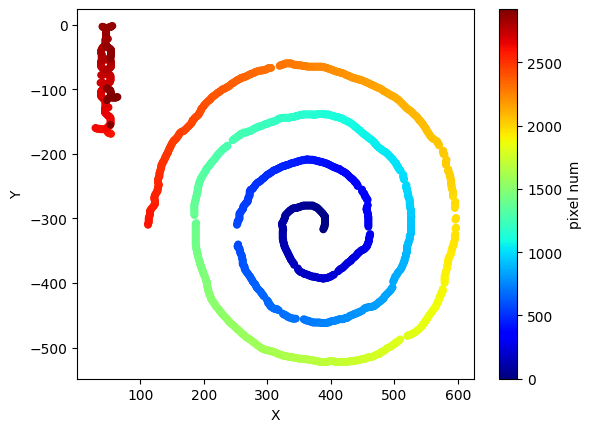

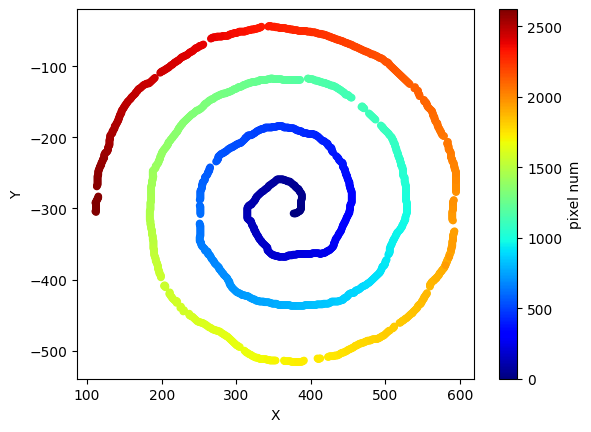

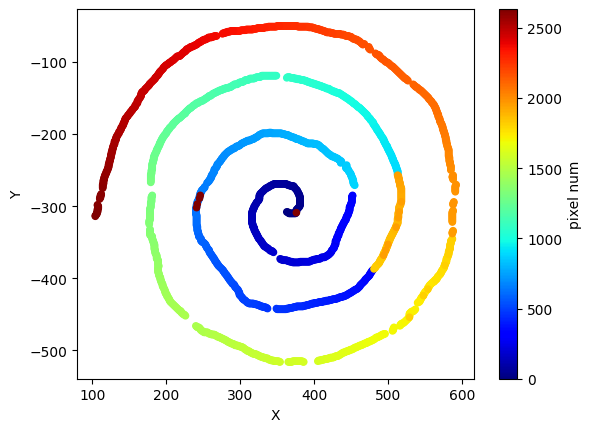

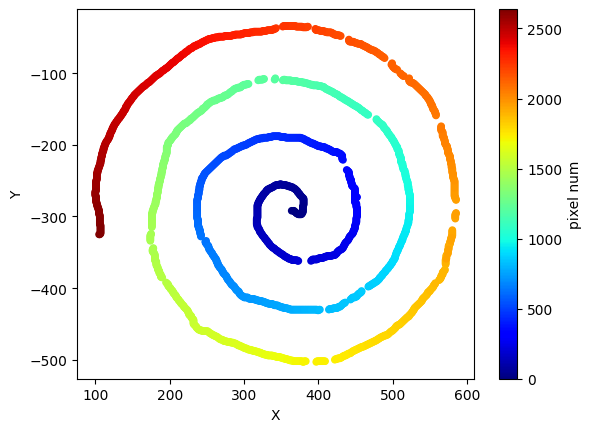

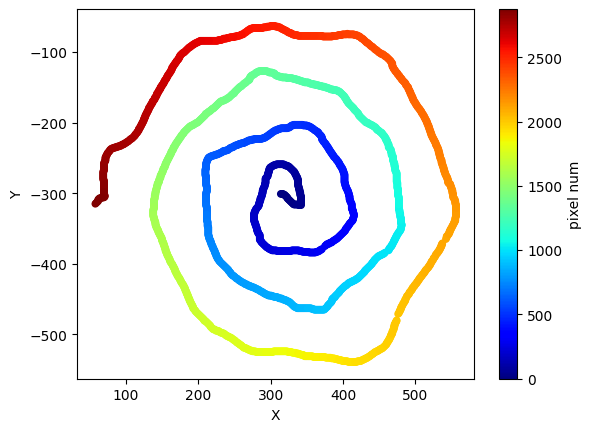

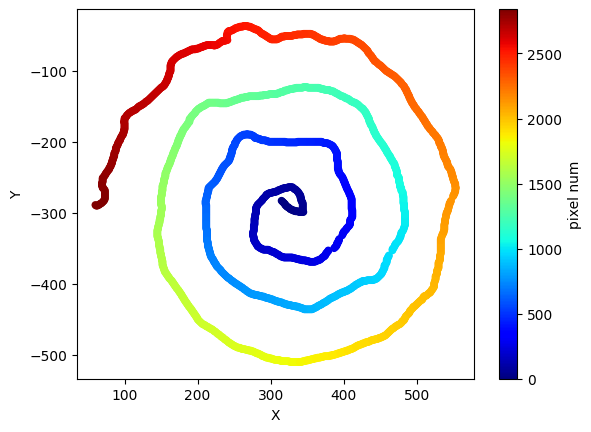

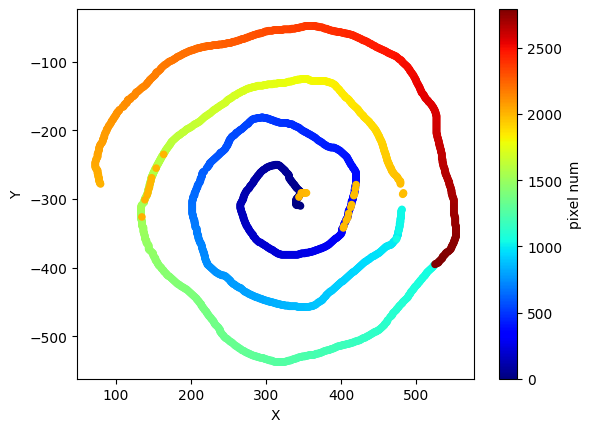

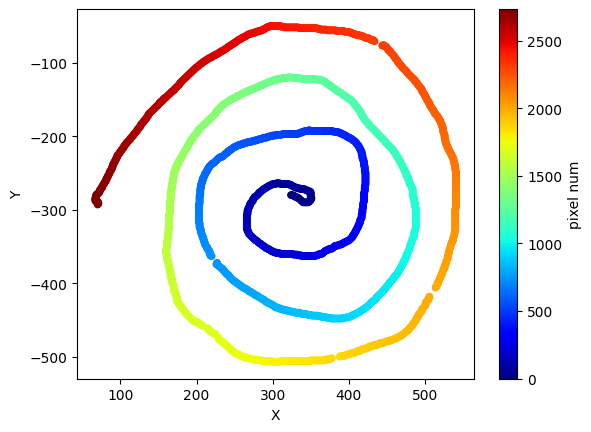

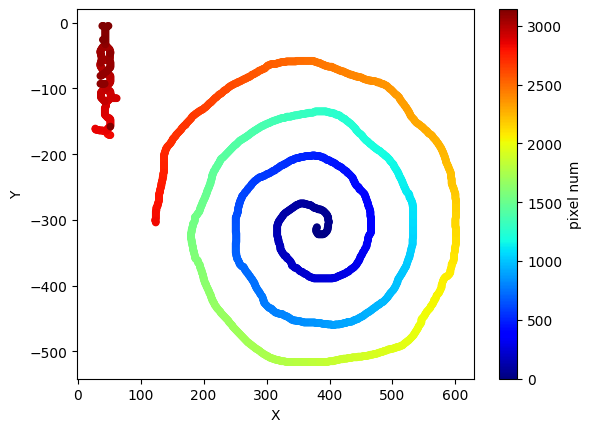

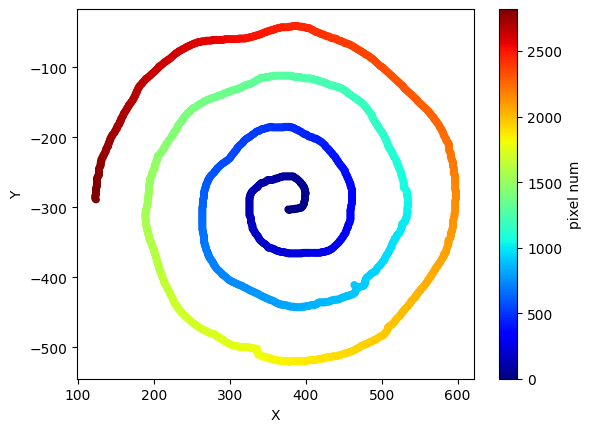

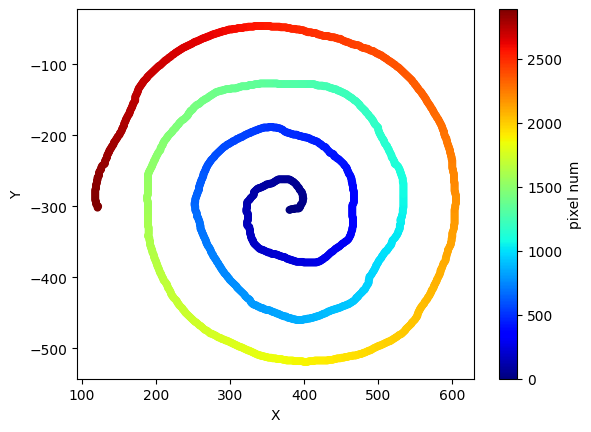

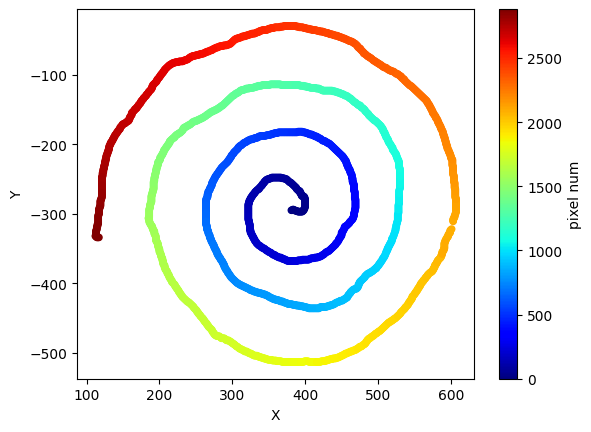

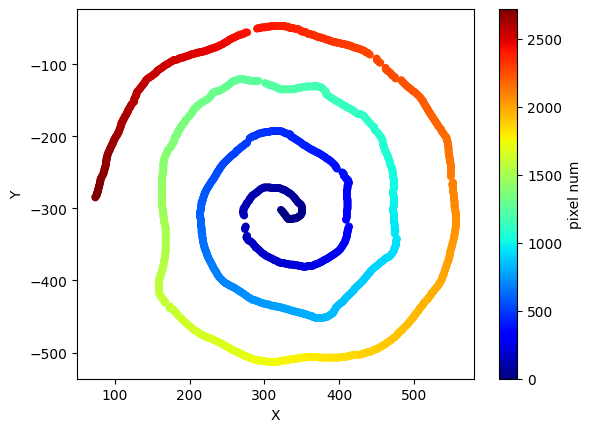

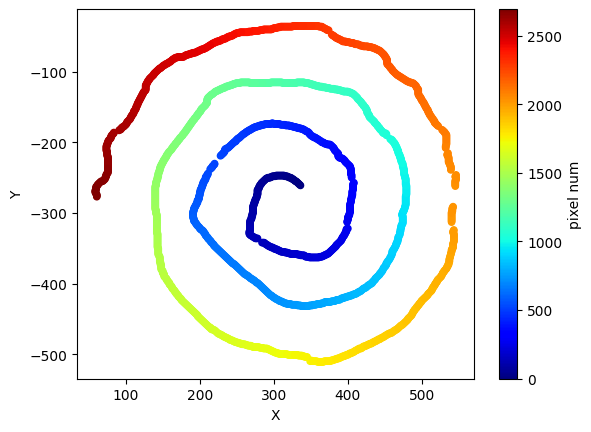

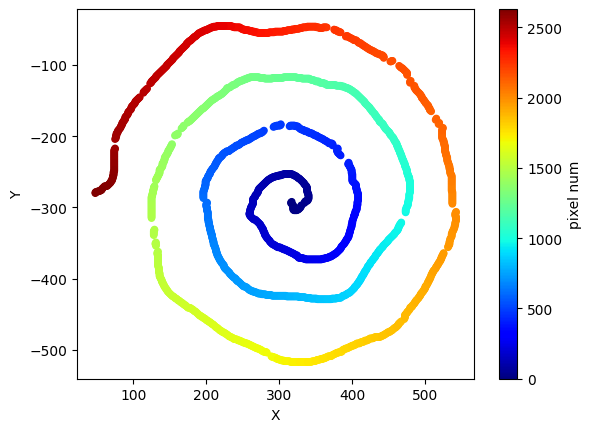

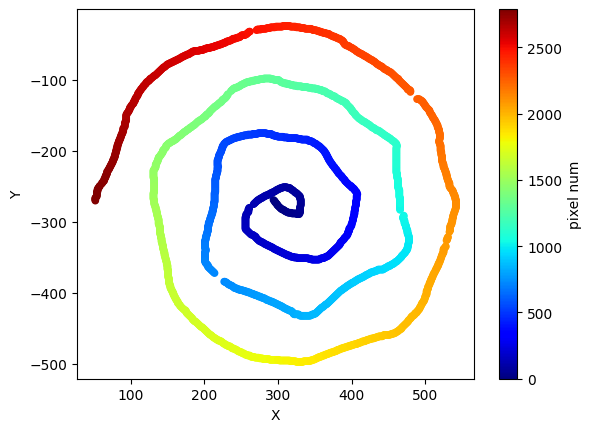

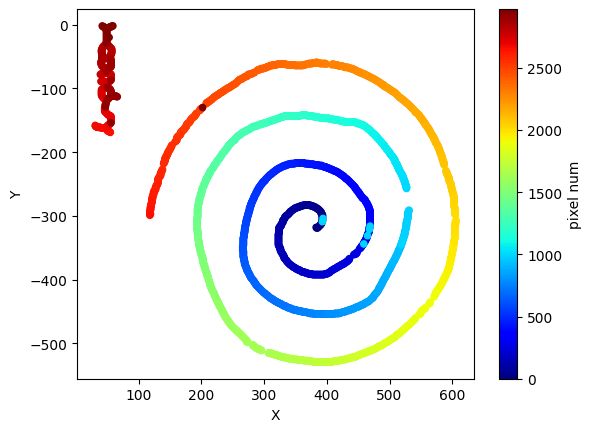

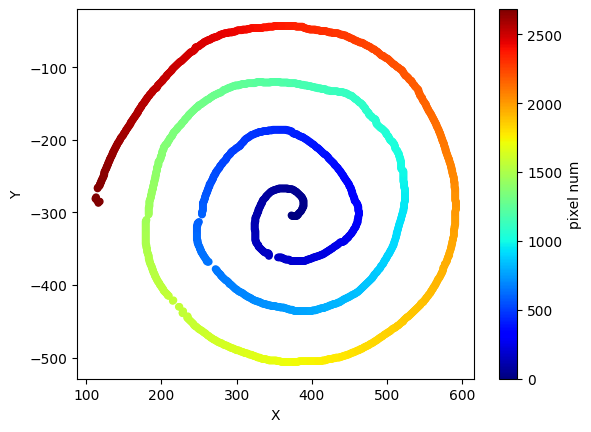

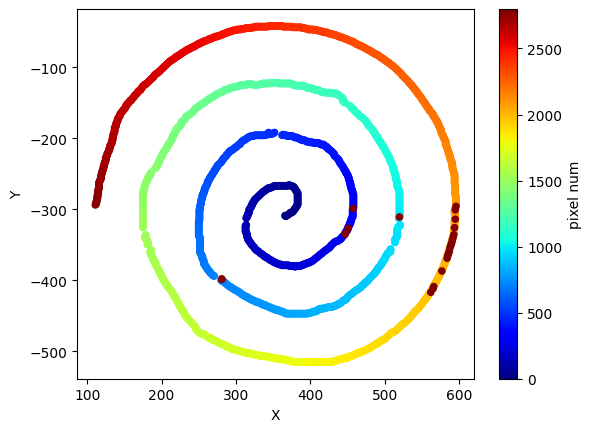

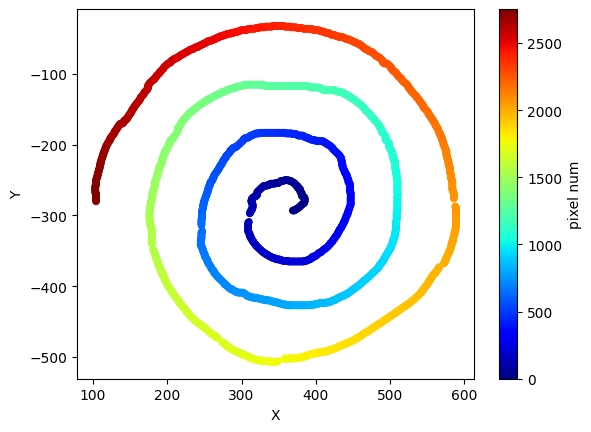

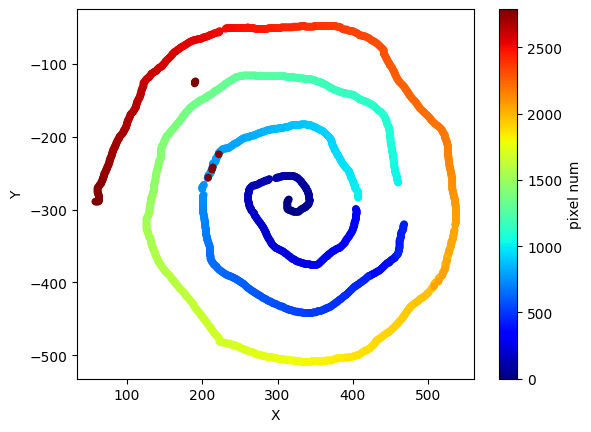

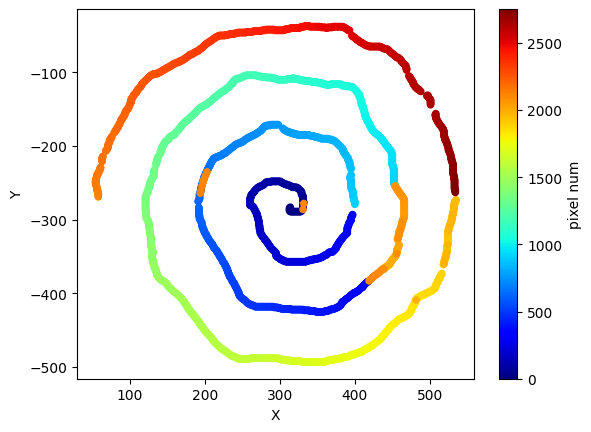

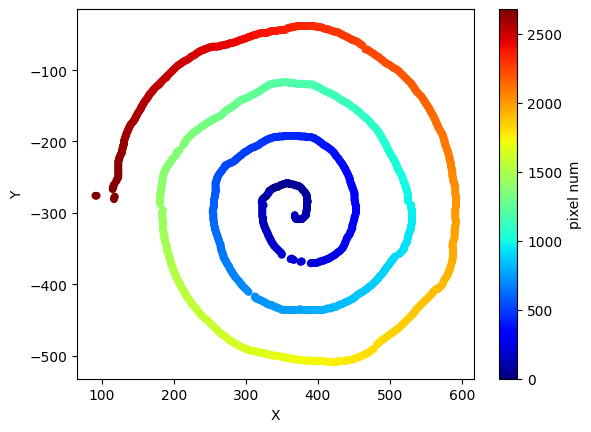

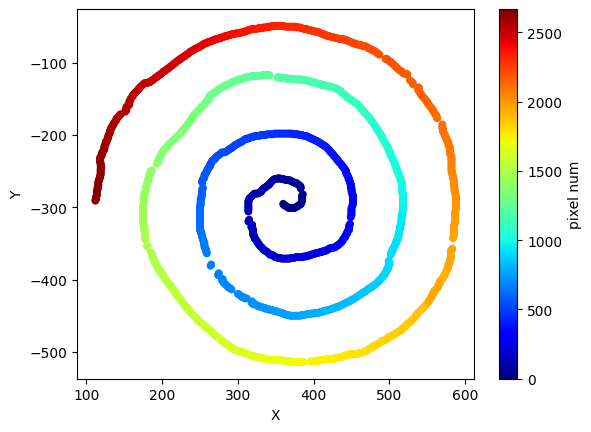

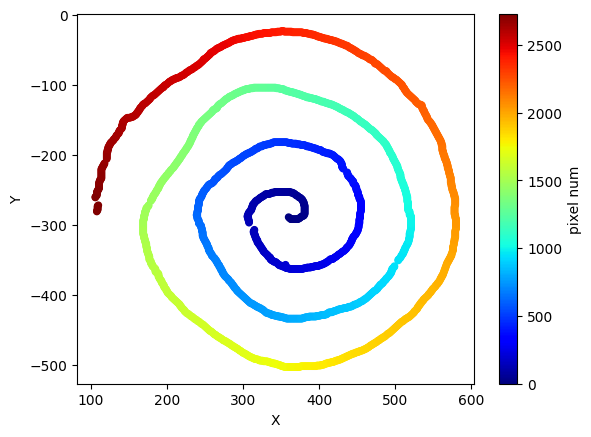

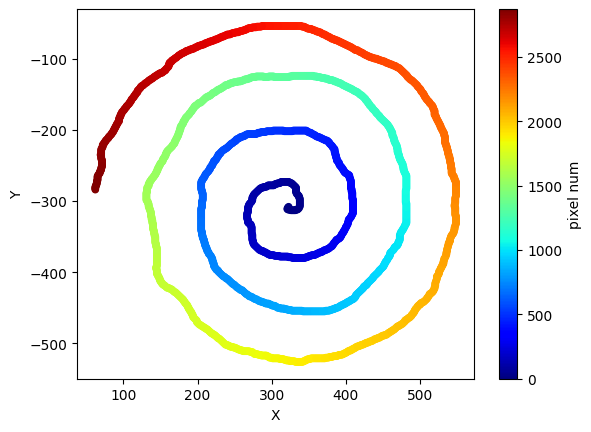

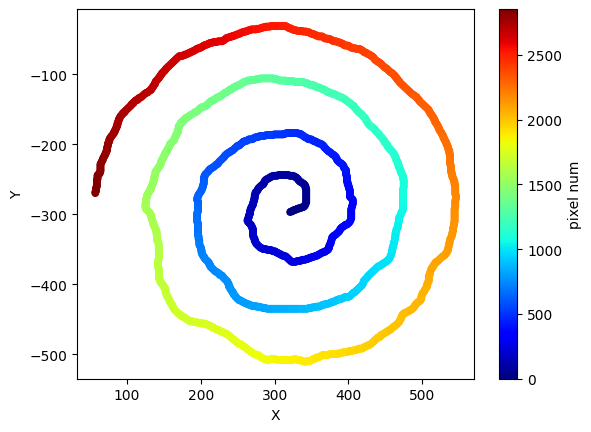

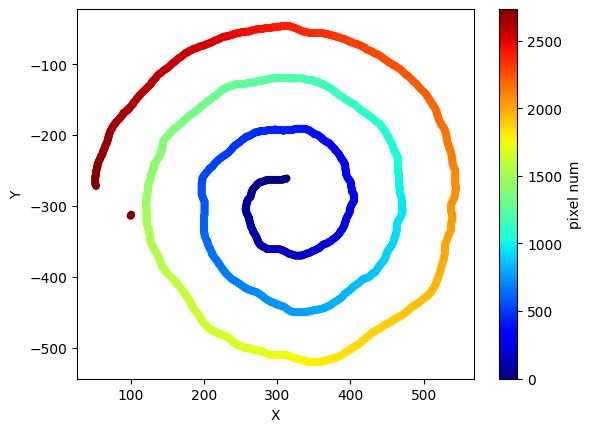

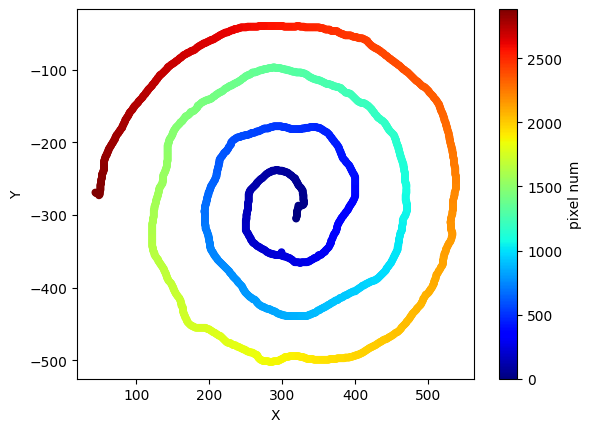

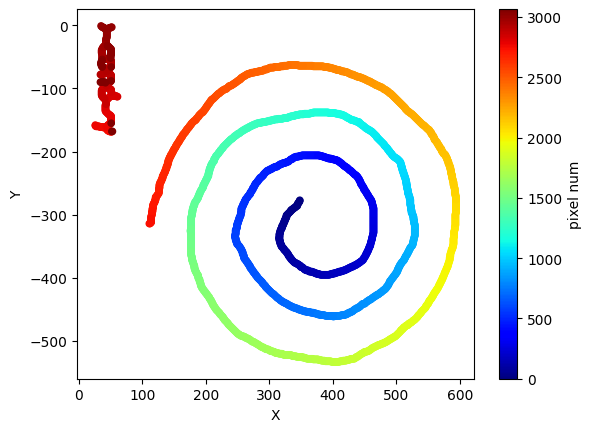

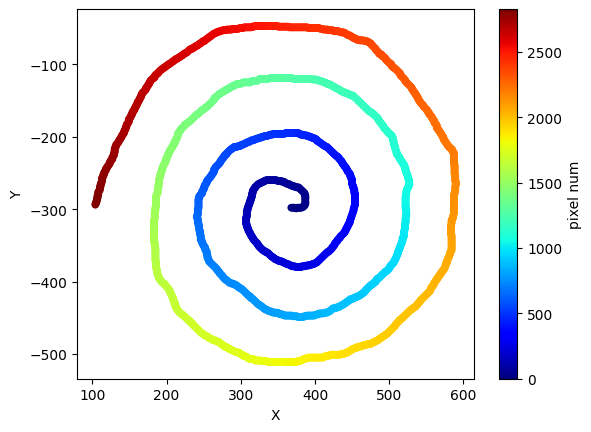

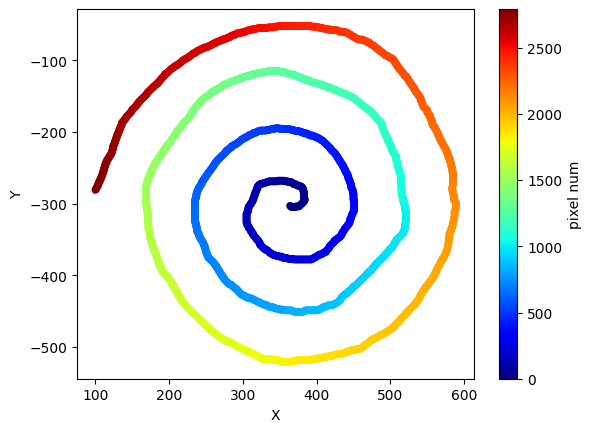

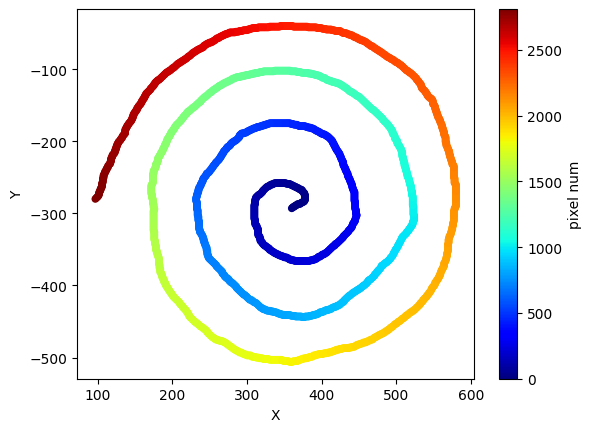

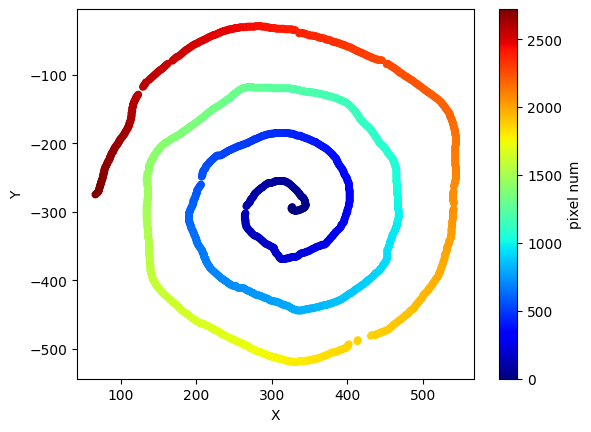

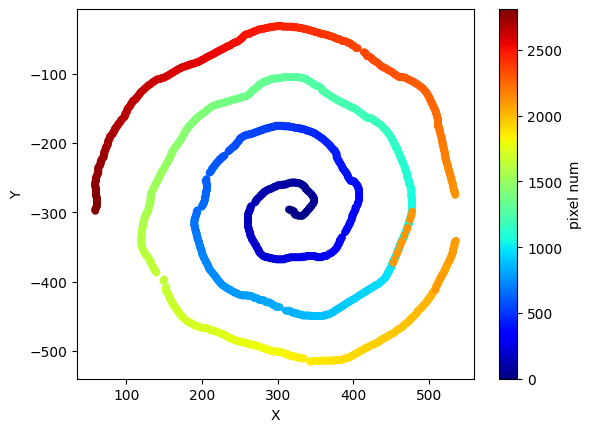

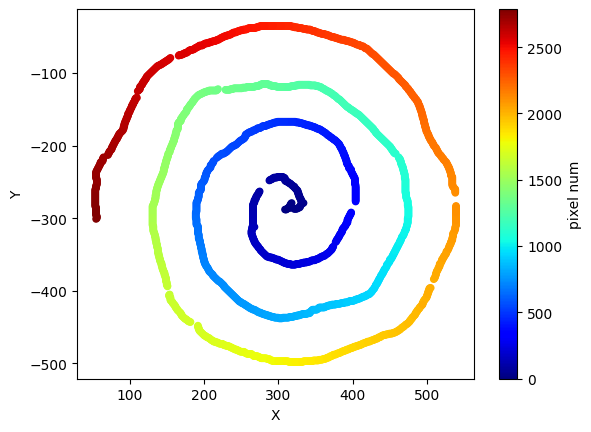

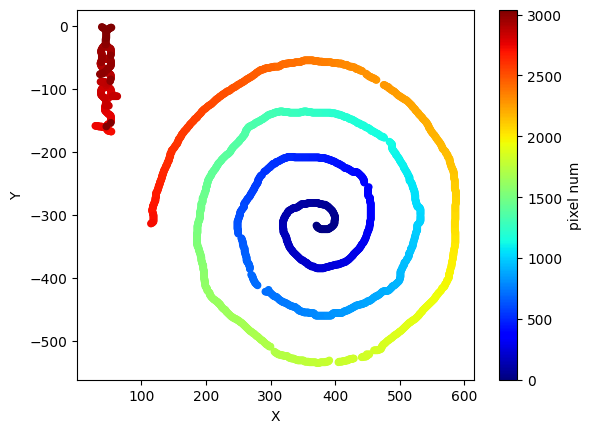

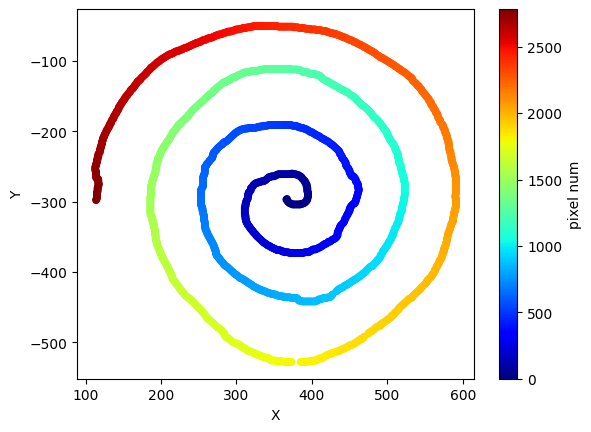

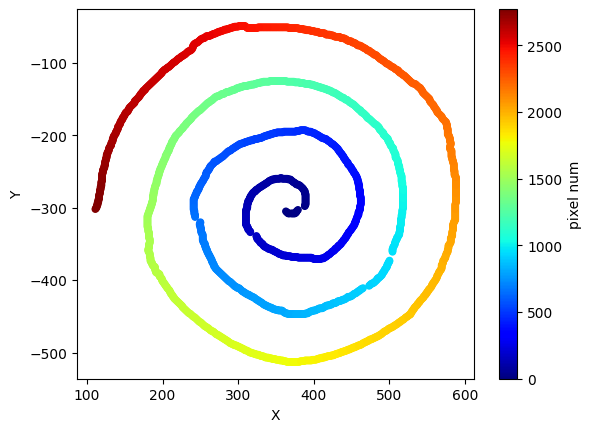

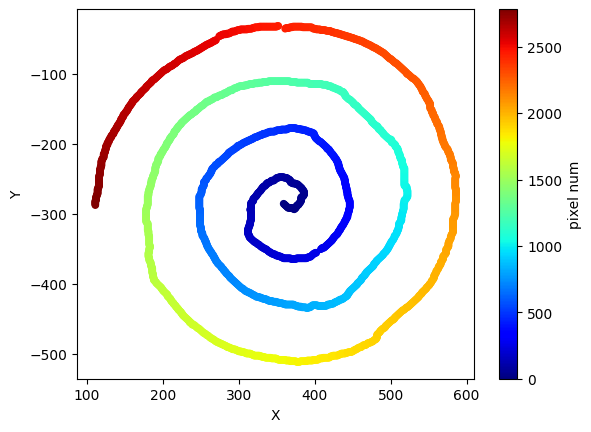

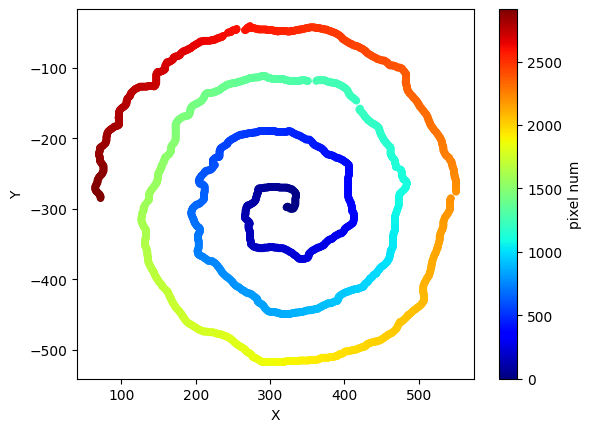

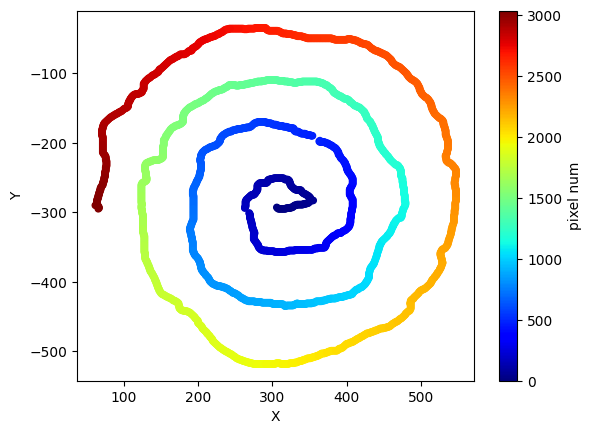

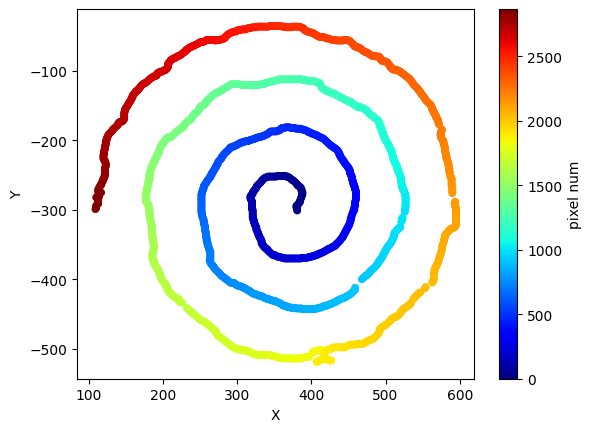

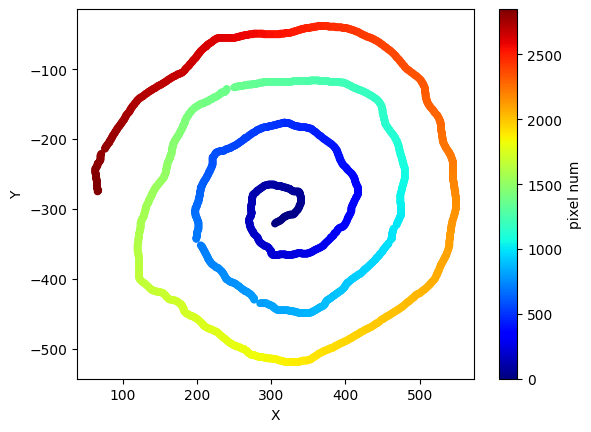

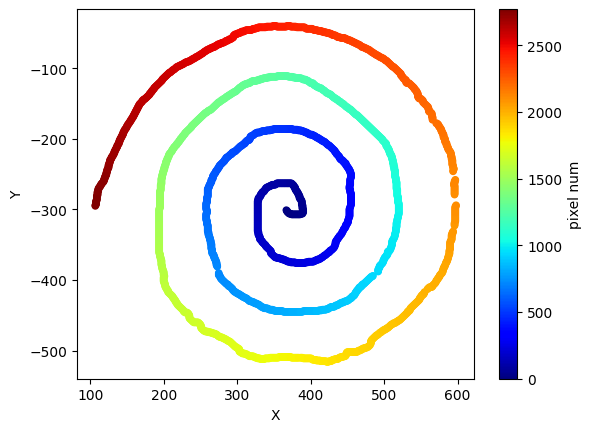

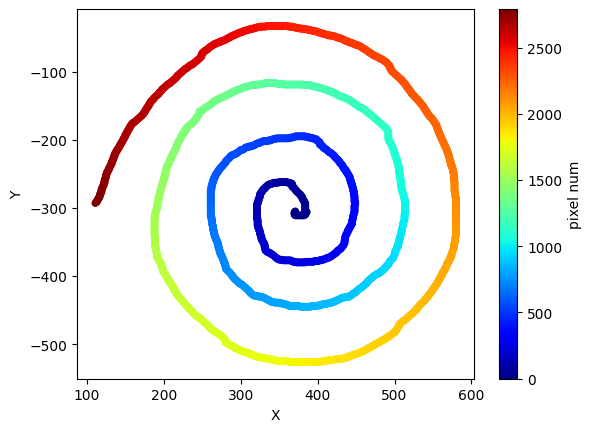

In [11]:
for i in all_paths:
    plt_traced(i, '')

In [26]:
df = {}

plt.figure(figsize=(10, 5))
for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    if True: #not 'dynamic' in name:
        x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
        reg = LinearRegression().fit(x, d2)
        pred = reg.predict(x)
        pad = 0
        d2 = list([0.0 for _ in range(pad)]) + list(d2)
        #print(d2)
        filtered = gaussian_filter1d(d2, 160)[pad:]
        filtered2 = gaussian_filter1d(d2, 30)[pad:]
        filtered3 = gaussian_filter1d(d2, 5)[pad:]
        d2 = d2[pad:]
        
        color = 'red' if name[4]=='0' else 'blue'
        plt.plot(d2[:-500], c=color, alpha=0.5)
        #plt.plot(pred, c='k')
        #plt.plot(filtered2, c='lightgrey')

        df[name]['dist2'] = d2
        df[name]['dist2_linreg'] = pred
        df[name]['dist2_filtered'] = filtered
        df[name]['dist2_filtered2'] = filtered2
        df[name]['dist2_filtered3'] = filtered3
        
plt.title('Squared Distance')
plt.show()

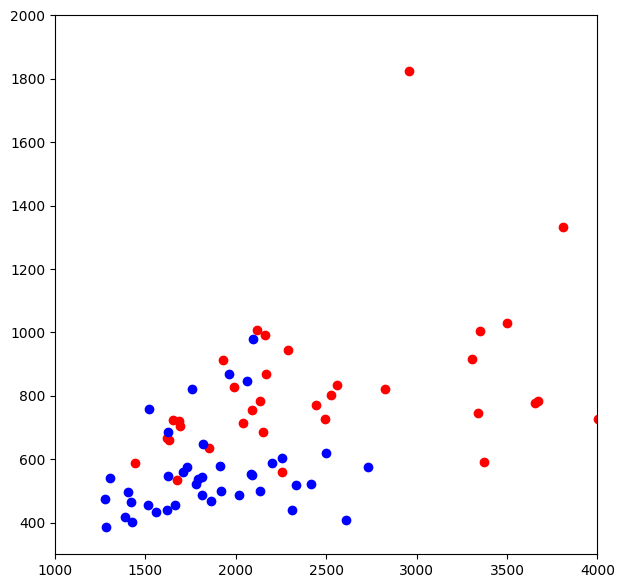

In [25]:
plt.figure(figsize=(7,7))
for name in df:
    if True:
        sa, ea = 10, -500
        sd, ed = 10, -500
        c = 'red' if name[4]=='0' else 'blue'
        x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
        y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
        #y = df[name]['inter']
        #y = df[name]['slope']
        
        #y = np.std([i-j for i, j in zip(df[name]['rad'][50:-50], df[name]['rad_filtered'][50:-50])])
        #y = np.std(df[name]['angle_alt'][50:-50])
        
        plt.scatter(x, y, c=c)
        #plt.text(x*1.01, y*1.01, name[:3], fontsize=7)
plt.xlim((1000, 4000))
plt.ylim((300, 2000))
plt.show()